## Simpler ECG with Lagging State Memory

In order to allow the RL models to learn communication, I'm modifying the ECG in two ways:
1. I'm decreasing the size of the game boards and the number of colors
2. I'm adding a 'lagging memory' to the Observation Space of each agent, consisting of the last 10 moves of the other agent, which should allow them to 'see' and react to any attempts by the other agent to communicate (which will necessarily occur over multiple in-game timesteps).

In [11]:
#General Imports
import os
from copy import copy
import functools
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt

# Gymnasium Imports
import gymnasium as gym
from gymnasium.spaces import Discrete
from gymnasium.utils import seeding

#PettingZoo and Supersuit Imports
from pettingzoo import ParallelEnv
from pettingzoo.test import parallel_api_test
import supersuit as ss

# SB3 Imports
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

from sb3_contrib import RecurrentPPO

#My Custom Functions
from functions import plot_results, plot_multi

In [2]:
class SimpleEmbodiedCommunicationGame(ParallelEnv):
    """
    My second attempt at creating emergent communication in the RL models. This game differs from the original in 2 ways:
    1. The grids are smaller with less possible colors
    2. The agents are fed the previous agents' previous 10 locations in addition to their current location. This allows the models to interpret
    behavior over time as communiction.
    """
    metadata = { "render_modes": [],
        "name":"SimpleEmbodiedCommunicationGame-v0"}
    
    def __init__(self, step_limit = 100):
        """
        Variables to instantiate:
        -2 2x1 Grids 
        -2 Agent locations (int)
        -Color List (3 colors)
        -Step Count
        -Step Limit
        -Possible Agents (agents)?
        -Lagging Memory (dict{a: np.array(1,10)})
        We will not initialize the agent locations or grid color patterns here, that will occur in self.reset().
        We instantiate the variables here to keep better track of them.
        """

        #public variables
        self.step_limit = step_limit
        self.possible_agents = ["agent1", "agent2"]
        self.render_mode = None
        self.spec = None
        
        #private variables
        self._step_count = 0

        #Grids, agent coords, and agents committed. To make step() easier, I'm going to put each of these into it's own
        # dict, with keys corresponding to agent names.
        self._color_grids = {a : np.zeros((2,)) for a in self.possible_agents}

        self._agent_coords = {a : -1 for a in self.possible_agents}

        #Track whether agents are committed.
        self._agents_committed = {a : False for a in self.possible_agents}
        
        #Lagging Memory for agent locations
        self._lagging_memory = {a : np.zeros((10,)) for a in self.possible_agents}
        
        #Dictionary to map action space to a direction on the Gridworld.
        self._action_to_direction = {
            0: -1, #Left,
            1: 1, #Right,
            2: 0, #Chill,
            3: 0, #Commit
        }
        
        #Color list
        self._colors = [[0,1],[0,2],[1,2]]
            
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """
        initialize the Env for play.
        Variables to initialize:
        -Agent locations
        -Color arrangements for each 2x2 grid
        -step-count
        -Agent committed flag
        """
        #call super().reset() with seed to set self.np_random with seed.
        self._seed(seed)

        #Reset flags
        self._step_count = 0

        #Instantiate self.agents to be a copy (by value) of self.possible_agents.
        self.agents = copy(self.possible_agents)
        
        #generate color grids by first generating the grid selections for each agent
        grid_choices = self.np_random.choice(3, size=(2,),replace=False)

        #Iteratively generate agent data, including grid color, agent location, and agent committed.
        for idx, a in enumerate(self.agents):
            self._color_grids[a] = self.np_random.permutation(self._colors[grid_choices[idx]])
            self._agent_coords[a] = self.np_random.integers(2)
            self._agents_committed[a] = False
            self._lagging_memory[a].fill(-1)
        
        #now to return obs and infos
        obs = self._get_obs()
        infos = self._get_infos()
        # print("obs: ",obs,"infos: ",infos, sep="\n\n")
        
        return obs, infos

    def step(self, actions):
        """
        update the Env according to the actions of each agent.
        returns:
        obs{}, rewards{}, terminateds{}, truncateds{}, infos{}
        """
        for (agent, action) in actions.items():
            #roll the lagging memory
            self._lagging_memory[agent] = np.roll(self._lagging_memory[agent],1)
            
            #update the agent committed status first.
            if action == 3:
                self._agents_committed[agent] = True
                
            #Update agent's coordinates only if agent not committed. Checking action != 4 for redundancy.
            if (self._agents_committed[agent] == False and action != 3):
                direction = self._action_to_direction[action]
                self._agent_coords[agent] = np.clip(self._agent_coords[agent] + direction, 0, 1)
                self._lagging_memory[agent][0] = self._agent_coords[agent]

        self._step_count += 1
        
        #Now calculate the return values.
        obs = self._get_obs()
        rewards, terminateds, truncateds = self._get_rewards_terminateds_truncateds()
        infos = self._get_infos()

        if all(terminateds.values()) or all(truncateds.values()):
            self.agents = []

        return obs, rewards, terminateds, truncateds, infos

    def _seed(self, seed = None):
        self.np_random, seed = seeding.np_random(seed)

    def _get_obs(self):
        #I tried getting fancy and generating this with a loop, but it was causing problems, so for now I'm just going
        # to make it by hand.
        a1 = self.agents[0]
        a2 = self.agents[1]
        obs = {
            a1 : {
                "myCoords" : self._agent_coords[a1],
                "theirCoords" : self._lagging_memory[a2],
                "myColors" : self._color_grids[a1],
            },
            a2 : {
                "myCoords" : self._agent_coords[a2],
                "theirCoords" : self._lagging_memory[a1],
                "myColors" : self._color_grids[a2],
            },
        }
                     
        return obs

    def _get_rewards_terminateds_truncateds(self):
        """
        this function will return the rewards, terminateds, and truncateds state.
        There is specific logic relating rewards to truncation and termination.
        """   
        #we're basically building up a long boolean check to see if the agents have both committed to squares of the
        # same color. For that reason, I'm going to shorten some of these variable names to make the boolean statement
        # more readable.
        a1 = self.agents[0]
        a2 = self.agents[1]
        grid1 = self._color_grids[a1]
        grid2 = self._color_grids[a2]
        a1_coords = self._agent_coords[a1]
        a2_coords = self._agent_coords[a2]

        #Common/base case for terminated/reward is Terminated = False and Reward = 0. I want to also punish agents for
        # not committing to speed up the process of committing at some point.
        rewards = {a: (-1 if self._step_count > self.step_limit else 0) for a in self.agents}
        terminateds = {a: False for a in self.agents}
        truncateds = {a : self._step_count > self.step_limit for a in self.agents}

        #If both of the agents have committed, Terminated = True.
        if (self._agents_committed[a1] == True and self._agents_committed[a2] == True):
            terminateds = {a : True for a in self.agents}
            
            #If the color of a1's square matches the color of a2's square, reward = 1. Noteably, we only reward
            # the agents for having matching square colors if both agents have chosen to commit to their squares.
            if (grid1[a1_coords] == grid2[a2_coords]):
                rewards = {a : 1 for a in self.agents}
        
        return rewards, terminateds, truncateds

    #TODO: Learn more about what I can use info for. this might be a way to give the agents some form of memory.
    def _get_infos(self):
        return {a : {} for a in self.agents}

    #Farama recommends using memo-ized functions for returning action_space and observation_space rather than public
    # or private class variables.
    @functools.lru_cache(maxsize=None)
    def observation_space(self,agent):
        return gym.spaces.Dict({
            "myCoords": gym.spaces.Discrete(2),
            "theirCoords": gym.spaces.Box(0,2, shape = (10,), dtype=np.float64),
            "myColors": gym.spaces.Box(0,3, shape = (2,), dtype=np.float64),
        })

    @functools.lru_cache(maxsize=None)
    def action_space(self,agent):
        return Discrete(4)

In [3]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "SECG-v0"
mPPO_dir = f"{log_dir}/{game}/mPPO/"
mA2C_dir = f"{log_dir}/{game}/mA2C/"
os.makedirs(mPPO_dir, exist_ok=True)
os.makedirs(mA2C_dir, exist_ok=True)

In [4]:
env = ss.pettingzoo_env_to_vec_env_v1(SimpleEmbodiedCommunicationGame())
env = ss.concat_vec_envs_v1(env, 10, base_class = "stable_baselines3")
env = VecMonitor(env, mPPO_dir)
model_path = f"{mPPO_dir}/best_model.zip"
mPPO = PPO.load(
    model_path,
    env)

mPPO.learn(1000000, callback = EvalCallback(env, best_model_save_path=mPPO_dir, eval_freq=20000, verbose=0), progress_bar=True)

env = ss.pettingzoo_env_to_vec_env_v1(SimpleEmbodiedCommunicationGame())
env = ss.concat_vec_envs_v1(env, 10, base_class = "stable_baselines3")
env = VecMonitor(env, mA2C_dir)
model_path = f"{mA2C_dir}/best_model.zip"
mA2C = A2C("MultiInputPolicy", env)

mA2C.learn(1000000, callback = EvalCallback(env, best_model_save_path=mA2C_dir, eval_freq=20000, verbose=0), progress_bar=True)

Output()

Output()

In [10]:
PPO_results=load_results(mPPO_dir)
A2C_results=load_results(mA2C_dir)
print(PPO_results.shape,A2C_results.shape)

(1000038, 4) (443334, 4)


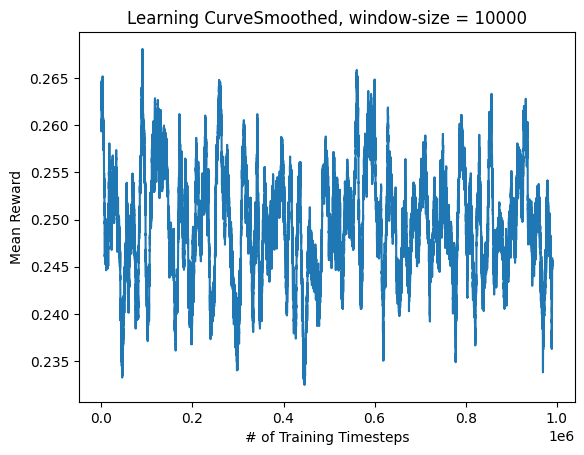

In [14]:
plot_results(mPPO_dir,window=10000)

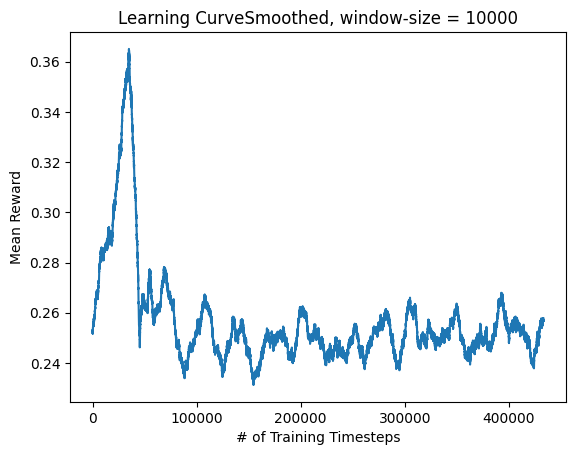

In [15]:
plot_results(mA2C_dir,window=10000)

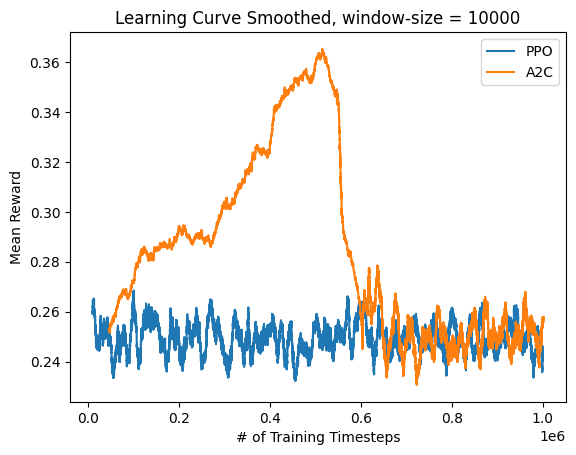

In [16]:
plot_multi([mPPO_dir,mA2C_dir],["PPO","A2C"],window=10000)

##### No communication occurred.
Unfortunately, while the model quickly converged on the local optimal strategy without communication, it didn't learn the more complex strategy of communicating its color options to its partner and coordinating on a particular color. It seems unlikely that an algorithm like PPO would deviate so far from an obvious local maximum in its policy as to find the optimal strategy. It's just too much of a leap for an optimization algorithm like that to reasonably make.

Possible options for solving this problem: perhaps there is a way to incentivise agents to communicate early on in multi-agent environments. Certainly, giving them a dedicated channel for communication would do the trick. But perhaps there's some incentive system which would encourage them to communicate aspects of their environment through their movements, even if they aren't sure anyone is listening.